# L06: IIoT Time Series Forecasting Lab
- Objective:

The goal of this lab is to apply time-series forecasting techniques to real-world IIoT data. You will preprocess the data, select and train appropiate models, perform feature engineering, evaluate model performance, and use generative models to enhance your dataset.

- Dataset:

Will be using the **IoT Temperature Forecasting** dataset on Kaggle. This dataset contains temperature sensor data from an IoT device and is suitable for time-series forecasting.

Dataset Link: https://www.kaggle.com/code/koheimuramatsu/iot-temperature-forecasting

## Intial EDA

In [1]:
# Install required libraries
%pip install nixtla pandas numpy scikit-learn mlforecast matplotlib inline
# Installing here in the virtual environment for convenience

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utilsforecast.plotting import plot_series

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data Loading and Preprocessing
df = pd.read_csv('IOT-temp.csv', parse_dates=['noted_date'])
df.head()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In


In [4]:
# Rename & Drop Columns
df2 = df.rename(columns={'id':'unique_id','noted_date':'ds','temp':'y'}, inplace=True)
df2 = df.drop(columns=['room_id/id','out/in'])

# Convert ds value into datetime format
df2['ds'] = pd.to_datetime(df2['ds'], format='%d-%m-%Y %H:%M')

In [5]:
df2.head()

,unique_id,ds,y
0,__export__.temp_log_196134_bd201015,2018-12-08 09:30:00,29
1,__export__.temp_log_196131_7bca51bc,2018-12-08 09:30:00,29
2,__export__.temp_log_196127_522915e3,2018-12-08 09:29:00,41
3,__export__.temp_log_196128_be0919cf,2018-12-08 09:29:00,41
4,__export__.temp_log_196126_d30b72fb,2018-12-08 09:29:00,31


In [6]:
df['unique_id'].value_counts()

unique_id
__export__.temp_log_196108_4a983c7e    2
__export__.temp_log_196134_bd201015    1
__export__.temp_log_12544_1a76a951     1
__export__.temp_log_134983_a6423bbe    1
__export__.temp_log_127926_3ba19d7a    1
                                      ..
__export__.temp_log_60241_79017f66     1
__export__.temp_log_60247_15b91351     1
__export__.temp_log_60243_af6d035d     1
__export__.temp_log_60245_13fc6805     1
__export__.temp_log_133741_32958703    1
Name: count, Length: 97605, dtype: int64

In [7]:
print('y' in df2.columns)

True


In [8]:
# Check for duplicates
df2[df2.duplicated()]

,unique_id,ds,y
11,__export__.temp_log_196108_4a983c7e,2018-12-08 09:25:00,42


In [9]:
df2.drop_duplicates(inplace=True)

In [10]:
# Adding a more simple numeric identifier for unique_id
df2['unique_id'] = df2['unique_id'].apply(lambda x : int(x.split('_')[6]))
df2.head(3)

,unique_id,ds,y
0,196134,2018-12-08 09:30:00,29
1,196131,2018-12-08 09:30:00,29
2,196127,2018-12-08 09:29:00,41


Text(0, 0.5, 'Temp')

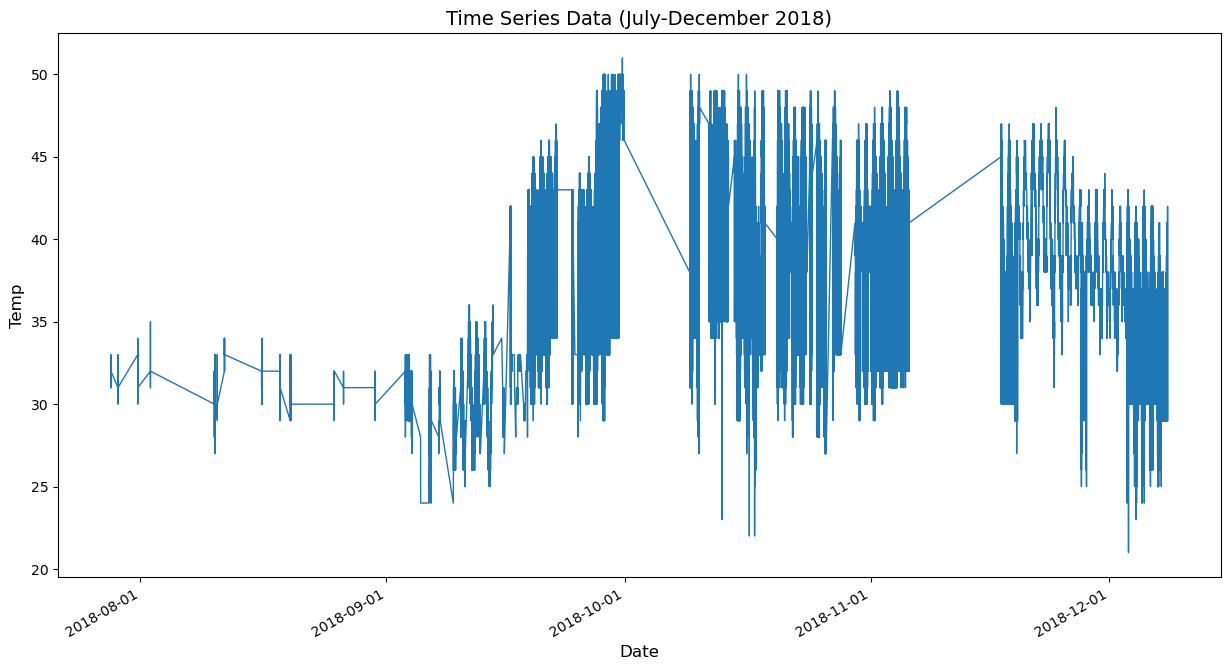

In [11]:
# Lets Visualize it
import matplotlib.dates as mdates

plt.figure(figsize=(15, 8))
plt.plot(df2['ds'], df2['y'], linewidth=1)

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels

# Add titles and labels
plt.title('Time Series Data (July-December 2018)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temp', fontsize=12)

## Model Training using MLForecast from Nixtla

In [12]:
# installing new libraries
%pip install lightgbm xgboost

Note: you may need to restart the kernel to use updated packages.


In [13]:
# importing new libraries
import random
import tempfile

import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from utilsforecast.feature_engineering import time_features

from mlforecast.lag_transforms import ExpandingMean, ExponentiallyWeightedMean, RollingMean
from mlforecast.lgb_cv import LightGBMCV
from mlforecast.target_transforms import Differences, LocalStandardScaler
from mlforecast.utils import generate_daily_series

In [14]:
# Prepping the Data
ids = df2['unique_id'].unique()
random.seed(0)
sample_ids = random.choices(ids, k=4)
sample_df = df2[df2['unique_id'].isin(sample_ids)]
sample_df

,unique_id,ds,y
25272,66671,2018-10-18 03:14:00,36
41050,53818,2018-10-17 13:47:00,40
73981,7809,2018-09-10 20:59:00,27
82420,136436,2018-09-10 08:31:00,31


In [15]:
    # Split the data into train and validation
    horizon = 48
    valid = sample_df.groupby('unique_id').tail(horizon)
    train = sample_df.drop(valid.index)
    train.shape, valid.shape

((0, 3), (4, 3))

In [22]:
# Examine the dataset size based on room IDs
print("Full dataset shape:", df.shape)
print("Number of unique rooms:", df['unique_id'].nunique())
print("Date range:", df['ds'].min(), "to", df['ds'].max())

Full dataset shape: (97606, 5)
Number of unique rooms: 97605
Date range: 01-11-2018 00:06 to 31-10-2018 23:57


In [23]:
# Filter rooms with sufficient data (at least 100 observations)
room_counts = df.groupby('unique_id').size()
valid_rooms = room_counts[room_counts >= 100].index.tolist()
print(f"Number of rooms with at least 100 observations: {len(valid_rooms)}")

Number of rooms with at least 100 observations: 0


In [25]:
# Select data from rooms with sufficient observations
analysis_df = df[df['unique_id'].isin(valid_rooms)]
print("Analysis dataset shape:", analysis_df.shape)

# Sort by unique_id and timestamp to ensure proper time series ordering
analysis_df = analysis_df.sort_values(['unique_id', 'ds'])

Analysis dataset shape: (0, 5)


In [26]:
# Check for missing timestamps or irregular intervals
print("\nChecking time intervals:")
interval_stats = []
for room in valid_rooms[:5]:  # Check first 5 rooms
    room_data = analysis_df[analysis_df['unique_id'] == room]
    if len(room_data) > 1:
        # Calculate time differences between consecutive timestamps
        time_diffs = room_data['ds'].diff().dropna()
        # Convert to minutes for readability
        mins = time_diffs.dt.total_seconds() / 60
        interval_stats.append({
            'room': room,
            'count': len(room_data),
            'min_interval_mins': mins.min(),
            'median_interval_mins': mins.median(),
            'max_interval_mins': mins.max()
        })


Checking time intervals:


In [27]:
# Display interval statistics
interval_df = pd.DataFrame(interval_stats)
print(interval_df)

Empty DataFrame
Columns: []
Index: []


In [28]:
top_rooms = room_counts.nlargest(5).index.tolist()
print(f"\nSelected top {len(top_rooms)} rooms for analysis: {top_rooms}")


Selected top 5 rooms for analysis: ['__export__.temp_log_196108_4a983c7e', '__export__.temp_log_100004_ea0b9f21', '__export__.temp_log_100005_f908c997', '__export__.temp_log_100007_e9852112', '__export__.temp_log_100009_51bd5a46']


In [29]:
# Create a smaller dataset with just these rooms
sample_df = analysis_df[analysis_df['unique_id'].isin(top_rooms)].copy()
print("Sample dataset shape:", sample_df.shape)

Sample dataset shape: (0, 5)
